## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [2, 16, 32, 128, 256]
MOMENTUM = 0.95

In [7]:
results = {}

for bs in BATCH_SIZE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with BATCH_SIZE = %d" % (bs))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=bs, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]

    exp_name_tag = "bs-%d" % bs
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}




Experiment with BATCH_SIZE = 2


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)

50000/50000 [==============================] - 149s 3ms/step - loss: 2.2442 - acc: 0.1653 - val_loss: 2.9231 - val_acc: 0.1537
Epoch 26/50
50000/50000 [==============================] - 154s 3ms/step - loss: 2.2377 - acc: 0.1632 - val_loss: 2.8851 - val_acc: 0.1625
Epoch 27/50
50000/50000 [==============================] - 149s 3ms/step - loss: 2.2354 - acc: 0.1659 - val_loss: 3.1648 - val_acc: 0.1929
Epoch 28/50
50000/50000 [==============================] - 151s 3ms/step - loss: 2.2415 - acc: 0.1647 - val_loss: 3.4013 - val_acc: 0.1754
Epoch 29/50
50000/50000 [==============================] - 149s 3ms/step - loss: 2.2360 - acc: 0.1653 - val_loss: 3.0577 - val_acc: 0.2116
Epoch 30/50
50000/50000 [==============================] - 151s 3ms/step - loss: 2.2267 - acc: 0.1717 - val_loss: 3.1076 - val_acc: 0.1810
Epoch 31/50
50000/50000 [==============================] - 150s 3ms/step - loss: 2.2309 - acc: 0.1718 - val_loss: 3.5998 - val_acc: 0.1717
Epoch 32/50
50000/50000 [==============

50000/50000 [==============================] - 20s 395us/step - loss: 1.2438 - acc: 0.5614 - val_loss: 1.3788 - val_acc: 0.5174
Epoch 24/50
50000/50000 [==============================] - 20s 401us/step - loss: 1.2295 - acc: 0.5642 - val_loss: 1.3672 - val_acc: 0.5219
Epoch 25/50
50000/50000 [==============================] - 19s 382us/step - loss: 1.2337 - acc: 0.5640 - val_loss: 1.3334 - val_acc: 0.5339
Epoch 26/50
50000/50000 [==============================] - 19s 382us/step - loss: 1.2185 - acc: 0.5701 - val_loss: 1.3612 - val_acc: 0.5147
Epoch 27/50
50000/50000 [==============================] - 20s 391us/step - loss: 1.2138 - acc: 0.5730 - val_loss: 1.3889 - val_acc: 0.5108
Epoch 28/50
50000/50000 [==============================] - 20s 391us/step - loss: 1.2071 - acc: 0.5701 - val_loss: 1.4133 - val_acc: 0.5026
Epoch 29/50
50000/50000 [==============================] - 19s 382us/step - loss: 1.2059 - acc: 0.5748 - val_loss: 1.3196 - val_acc: 0.5376
Epoch 30/50
50000/50000 [=======

50000/50000 [==============================] - 10s 193us/step - loss: 1.0778 - acc: 0.6148 - val_loss: 1.3882 - val_acc: 0.5262
Epoch 22/50
50000/50000 [==============================] - 10s 205us/step - loss: 1.0651 - acc: 0.6183 - val_loss: 1.4721 - val_acc: 0.4984
Epoch 23/50
50000/50000 [==============================] - 10s 194us/step - loss: 1.0494 - acc: 0.6251 - val_loss: 1.4312 - val_acc: 0.5060
Epoch 24/50
50000/50000 [==============================] - 9s 183us/step - loss: 1.0292 - acc: 0.6327 - val_loss: 1.4286 - val_acc: 0.5106
Epoch 25/50
50000/50000 [==============================] - 10s 194us/step - loss: 1.0157 - acc: 0.6383 - val_loss: 1.5060 - val_acc: 0.4935
Epoch 26/50
50000/50000 [==============================] - 9s 183us/step - loss: 1.0052 - acc: 0.6413 - val_loss: 1.4724 - val_acc: 0.5025
Epoch 27/50
50000/50000 [==============================] - 10s 195us/step - loss: 0.9983 - acc: 0.6429 - val_loss: 1.4929 - val_acc: 0.5088
Epoch 28/50
50000/50000 [=========

50000/50000 [==============================] - 4s 74us/step - loss: 0.7720 - acc: 0.7309 - val_loss: 1.8196 - val_acc: 0.4386
Epoch 20/50
50000/50000 [==============================] - 5s 91us/step - loss: 0.7539 - acc: 0.7351 - val_loss: 1.7067 - val_acc: 0.4722
Epoch 21/50
50000/50000 [==============================] - 4s 72us/step - loss: 0.7201 - acc: 0.7477 - val_loss: 1.7883 - val_acc: 0.4628
Epoch 22/50
50000/50000 [==============================] - 4s 74us/step - loss: 0.6961 - acc: 0.7577 - val_loss: 1.7581 - val_acc: 0.4660
Epoch 23/50
50000/50000 [==============================] - 4s 73us/step - loss: 0.6679 - acc: 0.7680 - val_loss: 1.7935 - val_acc: 0.4727
Epoch 24/50
50000/50000 [==============================] - 4s 84us/step - loss: 0.6462 - acc: 0.7760 - val_loss: 1.9431 - val_acc: 0.4419
Epoch 25/50
50000/50000 [==============================] - 3s 70us/step - loss: 0.6289 - acc: 0.7814 - val_loss: 1.7757 - val_acc: 0.4734
Epoch 26/50
50000/50000 [=====================

Epoch 18/50
50000/50000 [==============================] - 3s 60us/step - loss: 0.8087 - acc: 0.7233 - val_loss: 1.6439 - val_acc: 0.4593
Epoch 19/50
50000/50000 [==============================] - 3s 50us/step - loss: 0.7792 - acc: 0.7350 - val_loss: 1.5925 - val_acc: 0.4811
Epoch 20/50
50000/50000 [==============================] - 3s 50us/step - loss: 0.7480 - acc: 0.7447 - val_loss: 1.6968 - val_acc: 0.4703
Epoch 21/50
50000/50000 [==============================] - 2s 50us/step - loss: 0.7185 - acc: 0.7570 - val_loss: 1.6446 - val_acc: 0.4831
Epoch 22/50
50000/50000 [==============================] - 2s 50us/step - loss: 0.6910 - acc: 0.7673 - val_loss: 1.6837 - val_acc: 0.4770
Epoch 23/50
50000/50000 [==============================] - 3s 50us/step - loss: 0.6599 - acc: 0.7782 - val_loss: 1.6530 - val_acc: 0.4723
Epoch 24/50
50000/50000 [==============================] - 3s 58us/step - loss: 0.6347 - acc: 0.7869 - val_loss: 1.7165 - val_acc: 0.4713
Epoch 25/50
50000/50000 [=========

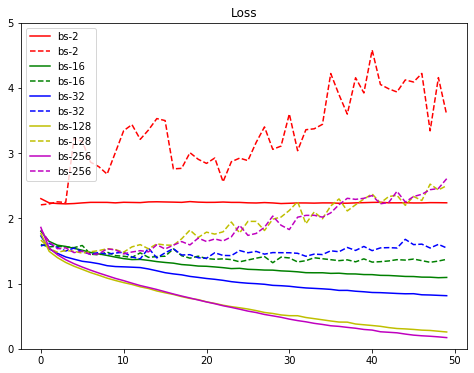

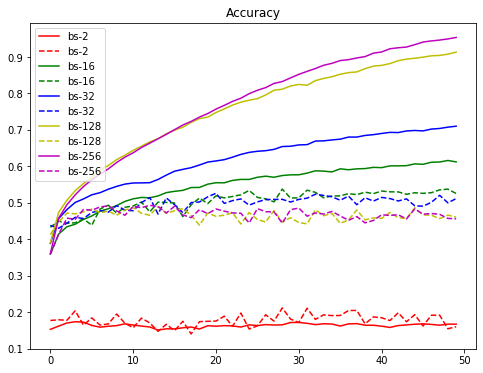

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()